In [23]:

import os
import tensorflow as tf
import keras
import numpy as np, glob, random, re, shutil
from sklearn.metrics import f1_score
from collections import Counter
from matplotlib import pyplot as plt


In [16]:

tf.random.set_seed(0)
np.random.seed(0)

# ─── 1. 路径配置 ───────────────────────────────────────────
DATA_DIR = "./dataset"
TRAIN_DIR = f"{DATA_DIR}/train"
DEV_DIR   = f"{DATA_DIR}/dev"
TEST_RAW  = f"{DATA_DIR}/test"       # 无标点
TEST_GOLD = f"{DATA_DIR}/test_gold"  # 带标点

# 若缺 dev/，从 train/ 抽 10 %
if not os.path.exists(DEV_DIR) or not os.listdir(DEV_DIR):
    os.makedirs(DEV_DIR, exist_ok=True)
    files = sorted(glob.glob(f"{TRAIN_DIR}/*.txt"))
    random.shuffle(files)
    for p in files[: int(0.1*len(files))]:
        shutil.move(p, f"{DEV_DIR}/{os.path.basename(p)}")


In [17]:

# ─── 2. 标签体系 ───────────────────────────────────────────
TAGS = ["O","COMMA","ENUM_COMMA","PERIOD","COLON","SEMICOLON",
        "QUES","EXCL","LQUO","RQUO","PAD"]
tag2id = {t:i for i,t in enumerate(TAGS)}
id2tag = {i:t for t,i in tag2id.items()}

PUNCT2TAG = {"，":"COMMA","、":"ENUM_COMMA","。":"PERIOD",
             "：":"COLON","；":"SEMICOLON","？":"QUES","！":"EXCL",
             "「":"LQUO","」":"RQUO"}

def make_example(text:str):
    chs, labs = [], []
    i = 0
    while i < len(text):
        ch = text[i]
        if ch in PUNCT2TAG:
            if labs: labs[-1] = PUNCT2TAG[ch]
            i += 1
        else:
            chs.append(ch); labs.append("O"); i += 1
    return chs, labs

def load_folder(folder, with_label=True):
    X, Y = [], []
    for fp in sorted(glob.glob(f"{folder}/*.txt")):
        txt = open(fp, encoding="utf-8").read().strip()
        if with_label: chs,lbs = make_example(txt)
        else:          chs,lbs = list(txt), ["O"]*len(txt)
        X.append(chs); Y.append(lbs)
    return X, Y

train_X, train_Y = load_folder(TRAIN_DIR, True)
dev_X,   dev_Y   = load_folder(DEV_DIR,   True)
test_X,  _       = load_folder(TEST_RAW,  False)
_,       gold_Y  = load_folder(TEST_GOLD, True)


In [18]:

# ─── 3. 字典 & 编码 ────────────────────────────────────────
PAD_ID, UNK_ID = 0,1
vocab = {"<PAD>":PAD_ID,"<UNK>":UNK_ID}
for seq in train_X:
    for ch in seq:
        if ch not in vocab: vocab[ch] = len(vocab)

def encode(seq, maxlen=256):
    ids = [vocab.get(c, UNK_ID) for c in seq][:maxlen]
    mask= [1]*len(ids)
    ids += [PAD_ID]*(maxlen-len(ids))
    mask+= [0]*(maxlen-len(mask))
    return ids, mask

def encode_dataset(X,Y,maxlen=256):
    xs,ys,ms = [],[],[]
    for chs,lbs in zip(X,Y):
        xi,mi = encode(chs,maxlen)
        yi = [tag2id[t] for t in lbs[:maxlen]] + [tag2id["PAD"]]*(maxlen-len(lbs))
        xs.append(xi); ys.append(yi); ms.append(mi)
    return np.array(xs),np.array(ys),np.array(ms,bool)

MAXLEN = 256
x_tr,y_tr,m_tr = encode_dataset(train_X,train_Y,MAXLEN)
x_dev,y_dev,m_dev = encode_dataset(dev_X,dev_Y,MAXLEN)
x_te,_,_ = encode_dataset(test_X,gold_Y,MAXLEN)

# 统计标签频次（不含 PAD）
label_counter = Counter(t for seq in train_Y for t in seq if t != "PAD")
total_tokens  = sum(label_counter.values())
num_classes   = len(TAGS)

# 公式：weight = total / (num_classes * freq)
class_weight = { tag2id[tag]: total_tokens / (num_classes * freq)
                 for tag, freq in label_counter.items() }


In [19]:

# ─── 4. 模型 ─────────────────────────────────────────────
EMB, HID = 256, 256
N_LABELS = len(TAGS)

inputs = keras.Input((MAXLEN,))
x      = keras.layers.Embedding(len(vocab), EMB, mask_zero=True)(inputs)
x      = keras.layers.Bidirectional(
           keras.layers.LSTM(HID, return_sequences=True))(x)
x      = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(100, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)

outputs = keras.layers.Dense(N_LABELS, activation="softmax")(x)   # ← 唯一输出层

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 256, 256)  │  1,221,120 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 256)       │          0 │ input_layer_10[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 256, 512)  │  1,050,624 │ embedding_10[0][… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256, 512)  │          0 │ bidirectional_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256, 100)  │     51,300 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256, 100)  │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256, 11)   │      1,111 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,324,155 (8.87 MB)

 Trainable params: 2,324,155 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:

# ── 4.5 生成 sample_weight (mask × class_weight) ────────────
freq = Counter(t for seq in train_Y for t in seq)

# 简单做法：freq 最大的 → 权重 1；其它权重 = sqrt(max_freq / freq)
max_f = max(freq.values())
weight_vec = np.ones(len(TAGS), dtype="float32")
for tag, f in freq.items():
    if tag == "PAD":        # PAD 一律 0，完全不计入 loss
        weight_vec[tag2id[tag]] = 0.0
    else:
        weight_vec[tag2id[tag]] = np.sqrt(max_f / f)

# 把权重映射到每个 token，再乘 mask
sw_tr  = weight_vec[y_tr] * m_tr
sw_dev = weight_vec[y_dev] * m_dev


In [22]:

# ─── 5. 训练 ───────────────────────────────────────────────
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["sparse_categorical_accuracy"], 
    metrics=["accuracy"],
)


history = model.fit(
    x_tr, y_tr, sample_weight=sw_tr,
    validation_data=(x_dev, y_dev, sw_dev),
    batch_size=32, epochs=30,
    callbacks=[keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True)],
    verbose=2
)


Epoch 1/30
3/3 - 5s - 2s/step - accuracy: 0.7839 - loss: 1.7955 - sparse_categorical_accuracy: 0.5880 - val_accuracy: 0.8052 - val_loss: 1.9798 - val_sparse_categorical_accuracy: 0.5792
Epoch 2/30
3/3 - 2s - 803ms/step - accuracy: 0.7896 - loss: 1.6955 - sparse_categorical_accuracy: 0.6109 - val_accuracy: 0.8179 - val_loss: 1.9516 - val_sparse_categorical_accuracy: 0.5854
Epoch 3/30
3/3 - 3s - 889ms/step - accuracy: 0.7916 - loss: 1.6027 - sparse_categorical_accuracy: 0.6219 - val_accuracy: 0.8091 - val_loss: 1.9083 - val_sparse_categorical_accuracy: 0.5896
Epoch 4/30
3/3 - 2s - 742ms/step - accuracy: 0.7849 - loss: 1.5142 - sparse_categorical_accuracy: 0.6383 - val_accuracy: 0.8037 - val_loss: 1.8267 - val_sparse_categorical_accuracy: 0.6150
Epoch 5/30
3/3 - 2s - 826ms/step - accuracy: 0.7552 - loss: 1.4514 - sparse_categorical_accuracy: 0.6491 - val_accuracy: 0.8081 - val_loss: 1.8009 - val_sparse_categorical_accuracy: 0.6189
Epoch 6/30
3/3 - 4s - 1s/step - accuracy: 0.7753 - loss: 1

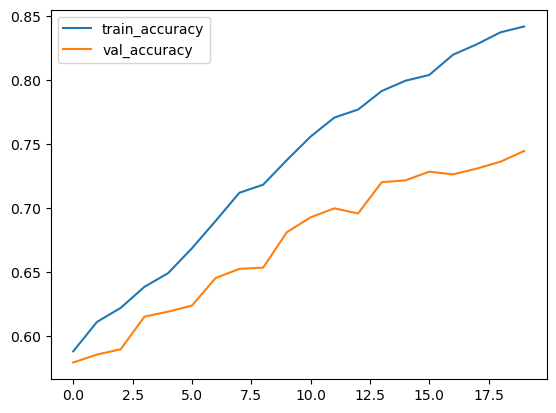

In [24]:
plt.plot(history.history["sparse_categorical_accuracy"], label="train_accuracy")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

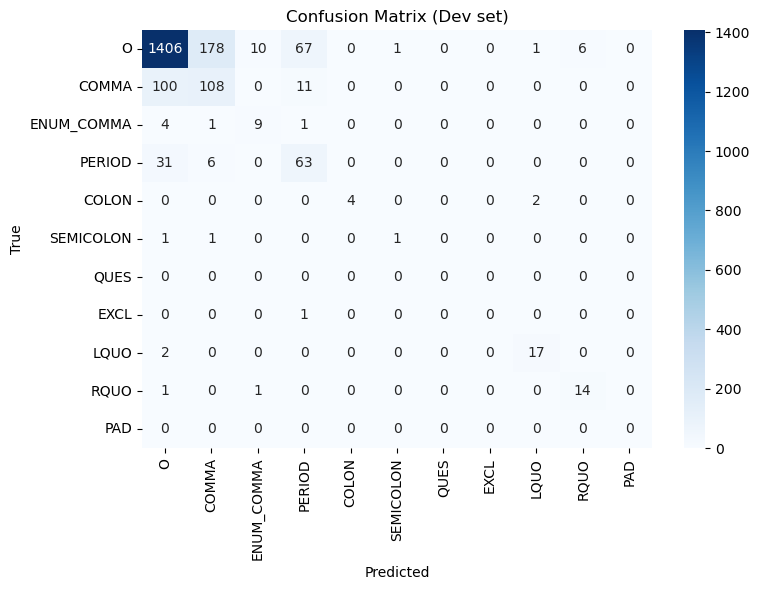

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ① 预测 dev
proba_dev = model.predict(x_dev, batch_size=32, verbose=0)
pred_dev  = proba_dev.argmax(-1)

# ② 展平成 1-D，只保留非 PAD 位
y_true_flat, y_pred_flat = [], []
for t, p, m in zip(y_dev, pred_dev, m_dev):
    valid = m.astype(bool)
    y_true_flat.extend(t[valid])
    y_pred_flat.extend(p[valid])

# ③ 计算混淆矩阵
cm = confusion_matrix(y_true_flat, y_pred_flat,
                      labels=list(range(len(TAGS))))

# ④ 可视化
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=TAGS, yticklabels=TAGS)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Dev set)')
plt.tight_layout()
plt.show()